# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.18MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.97MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# The model
Let's start with the model we first saw

In [81]:
import torch.nn.functional as F
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        ) # output_size = 4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [82]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,008
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [85]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [86]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1,cooldown=5)


EPOCHS = 14
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step(test_losses[epoch])
    print(f"Learning Rate = {optimizer.param_groups[0]['lr']}\n")
    if (test_acc[epoch] > 99.4):
      break

EPOCH: 0


Loss=0.20087343454360962 Batch_id=468 Accuracy=89.87: 100%|██████████| 469/469 [00:24<00:00, 19.12it/s]



Test set: Average loss: 0.0862, Accuracy: 9768/10000 (97.68%)

Learning Rate = 0.01

EPOCH: 1


Loss=0.07393189519643784 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:23<00:00, 20.30it/s]



Test set: Average loss: 0.0424, Accuracy: 9877/10000 (98.77%)

Learning Rate = 0.01

EPOCH: 2


Loss=0.050423383712768555 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]



Test set: Average loss: 0.0353, Accuracy: 9893/10000 (98.93%)

Learning Rate = 0.01

EPOCH: 3


Loss=0.04355016350746155 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:24<00:00, 19.31it/s]



Test set: Average loss: 0.0284, Accuracy: 9912/10000 (99.12%)

Learning Rate = 0.01

EPOCH: 4


Loss=0.10133826732635498 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]



Test set: Average loss: 0.0259, Accuracy: 9924/10000 (99.24%)

Learning Rate = 0.01

EPOCH: 5


Loss=0.044277373701334 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:23<00:00, 19.89it/s]



Test set: Average loss: 0.0247, Accuracy: 9915/10000 (99.15%)

Learning Rate = 0.01

EPOCH: 6


Loss=0.05868401750922203 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:21<00:00, 21.36it/s]



Test set: Average loss: 0.0283, Accuracy: 9904/10000 (99.04%)

Learning Rate = 0.01

EPOCH: 7


Loss=0.005332636181265116 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]



Test set: Average loss: 0.0250, Accuracy: 9914/10000 (99.14%)

Learning Rate = 0.001

EPOCH: 8


Loss=0.009366445243358612 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]



Test set: Average loss: 0.0202, Accuracy: 9928/10000 (99.28%)

Learning Rate = 0.001

EPOCH: 9


Loss=0.12549889087677002 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]



Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

Learning Rate = 0.001

EPOCH: 10


Loss=0.03044426254928112 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]



Test set: Average loss: 0.0196, Accuracy: 9935/10000 (99.35%)

Learning Rate = 0.001

EPOCH: 11


Loss=0.003603430697694421 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]



Test set: Average loss: 0.0186, Accuracy: 9936/10000 (99.36%)

Learning Rate = 0.001

EPOCH: 12


Loss=0.062174852937459946 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]



Test set: Average loss: 0.0190, Accuracy: 9935/10000 (99.35%)

Learning Rate = 0.001

EPOCH: 13


Loss=0.0034210896119475365 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:22<00:00, 21.29it/s]



Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)

Learning Rate = 0.001



# Let's Train and test our model

This time let's add a scheduler for out LR.

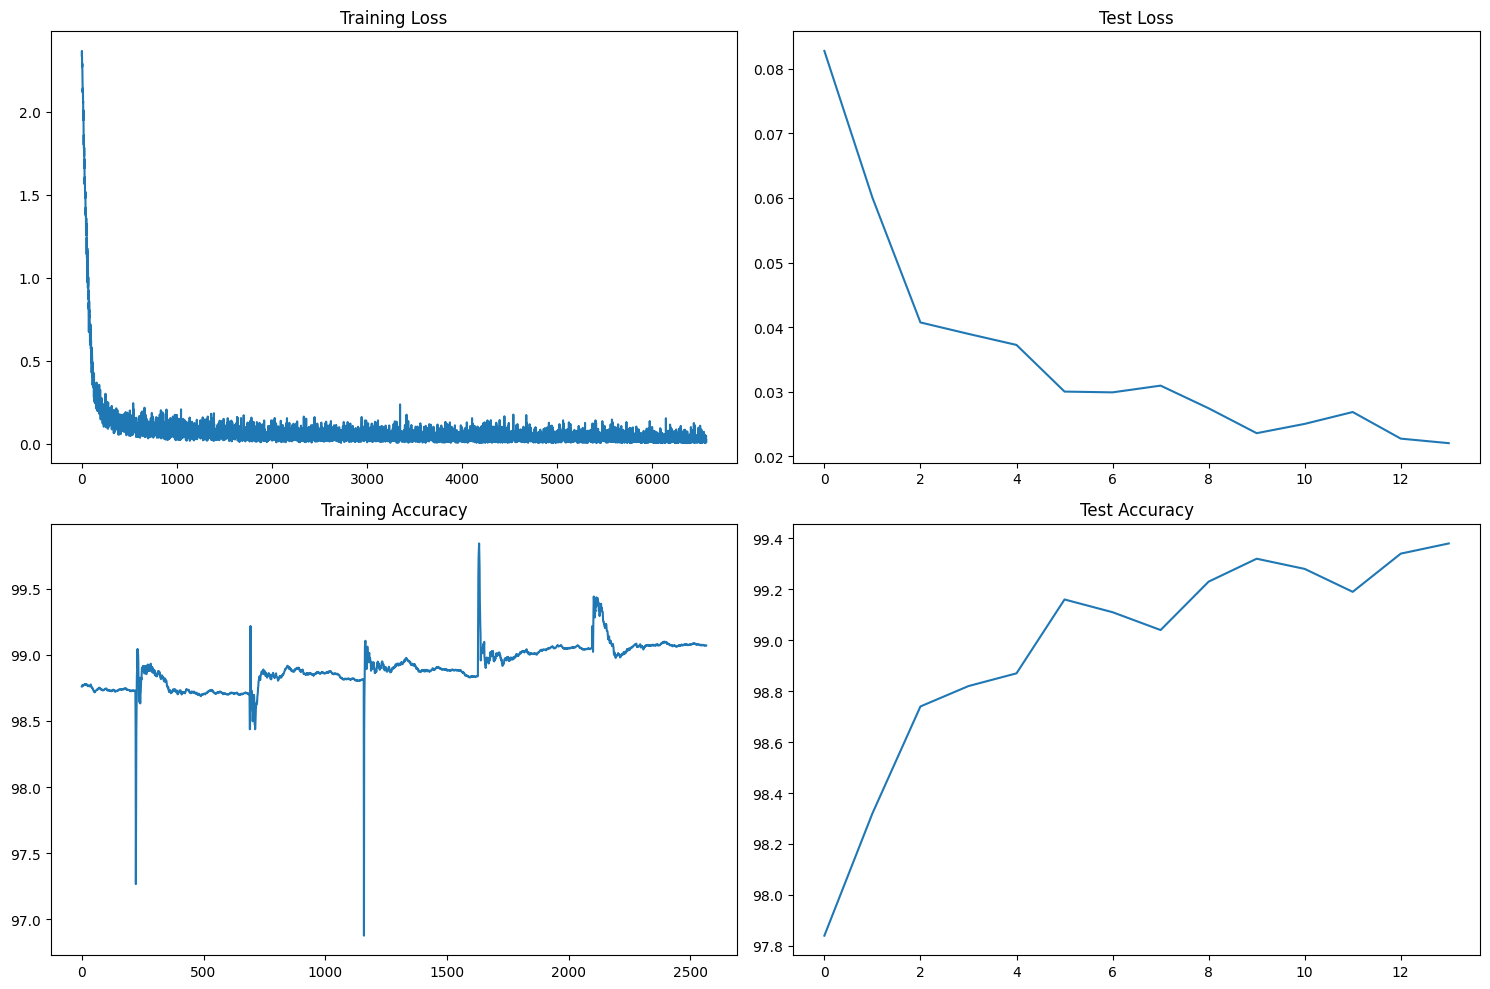

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt

#fig, axs = plt.subplots(2,2,figsize=(15,10))
#axs[0, 0].plot(train_losses)
#axs[0, 0].set_title("Training Loss")
#axs[1, 0].plot(train_acc[4000:])
#axs[1, 0].set_title("Training Accuracy")
#axs[0, 1].plot(test_losses)
#axs[0, 1].set_title("Test Loss")
#axs[1, 1].plot(test_acc)
#axs[1, 1].set_title("Test Accuracy")


fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Convert lists of tensors to lists of NumPy arrays, detaching if necessary
if isinstance(train_losses, list):
    train_losses = [x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x for x in train_losses]

if isinstance(train_acc, list):
    train_acc = [x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x for x in train_acc]

if isinstance(test_losses, list):
    test_losses = [x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x for x in test_losses]

if isinstance(test_acc, list):
    test_acc = [x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x for x in test_acc]

# Flatten lists of NumPy arrays (if necessary)
train_losses = [x.item() if hasattr(x, 'item') else x for x in train_losses]
train_acc = [x.item() if hasattr(x, 'item') else x for x in train_acc]
test_losses = [x.item() if hasattr(x, 'item') else x for x in test_losses]
test_acc = [x.item() if hasattr(x, 'item') else x for x in test_acc]

# Plot the processed data
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

plt.tight_layout()
plt.show()

